## Problem Statement
iPrint is an upcoming media house in India that offers media and information services to the people. The company’s business extends across a wide range of media, including news and information services on sports, weather, education, health, research, stocks and healthcare. Over the years, through its online application, iPrint has been efficiently delivering news and information to the common people. However, with time and technological advancements, several new competitors of iPrint have emerged in the market. Hence, it has decided to begin providing a more personalised experience to its customers.

The problem statement can be divided into two parts.

- Recommend new top 10 relevant articles to a user when he visits the app at the start of the day
- Recommend top 10 similar news articles that match the ones clicked by the user.

You have to ensure that the system does not recommend any news article that has been pulled out from the app or has already been seen by the user. In addition, only the articles that are written in the English language must be considered for content-based recommendations. The final generated list must contain the names of the recommended articles, along with their IDs.

## Load the requred libraries

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.corpora.dictionary import Dictionary
import string
from gensim.models.tfidfmodel import TfidfModel

from gensim.similarities import MatrixSimilarity

## Loading Data
The datasets provided are 'cosumer_transactions' which has the user data and 'platform_content' which has the item data

In [2]:
df_consumer = pd.read_csv(r'data/consumer_transanctions.csv', low_memory=False)
df_platform = pd.read_csv(r'data/platform_content.csv')

## EDA - consumer data

In [3]:
df_consumer.shape

(72312, 8)

In [4]:
df_consumer.head()

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country
0,1465413032,content_watched,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,content_watched,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,content_watched,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,content_followed,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,content_watched,-7820640624231356730,-445337111692715325,561148 1178424124714,NaN,NaN,NaN


In [5]:
df_consumer.describe()

,event_timestamp,item_id,consumer_id
count,7.231200e+04,7.231200e+04,7.231200e+04
mean,1.470103e+09,-3.033423e+16,1.252026e+16
std,7.258130e+06,5.344755e+18,5.022333e+18
min,1.457964e+09,-9.222795e+18,-9.223122e+18
25%,1.464876e+09,-4.726309e+18,-3.596627e+18
50%,1.468343e+09,1.893099e+16,-1.088422e+17
75%,1.474461e+09,4.441012e+18,3.766319e+18
max,1.488310e+09,9.222265e+18,9.210531e+18


In [6]:
df_consumer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72312 entries, 0 to 72311
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   event_timestamp       72312 non-null  int64 
 1   interaction_type      72312 non-null  object
 2   item_id               72312 non-null  int64 
 3   consumer_id           72312 non-null  int64 
 4   consumer_session_id   72312 non-null  object
 5   consumer_device_info  56918 non-null  object
 6   consumer_location     56907 non-null  object
 7   country               56918 non-null  object
dtypes: int64(3), object(5)
memory usage: 4.4+ MB


**We can see that the columns 'item_id' and 'consumer_id' do not have any null values. Null values are present in columns 'consumer_device_info', 'consumer_location' and 'country'**      

In [7]:
#Creating a Label Encoder for easy interpretation of Consumer ID 

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_consumer["consumer_index"] = le.fit_transform(df_consumer["consumer_id"])

In [8]:
df_consumer.head()

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country,consumer_index
0,1465413032,content_watched,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN,33
1,1465412560,content_watched,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US,831
2,1465416190,content_watched,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN,826
3,1465413895,content_followed,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN,974
4,1465412290,content_watched,-7820640624231356730,-445337111692715325,561148 1178424124714,NaN,NaN,NaN,887


### Creating a new ratings column and assigning values based on interaction type

In [9]:
df_consumer.interaction_type.unique()

array(['content_watched', 'content_followed', 'content_saved',
       'content_liked', 'content_commented_on'], dtype=object)

In [10]:
#Assigning values based on priority chart

chart = {'content_followed':5,
        'content_commented_on':4,
        'content_saved':3,
        'content_liked':2,
        'content_watched': 1
        }

In [11]:
df_consumer["ratings"] = df_consumer["interaction_type"].map(chart)

In [12]:
df_consumer.head()

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country,consumer_index,ratings
0,1465413032,content_watched,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN,33,1
1,1465412560,content_watched,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US,831,1
2,1465416190,content_watched,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN,826,1
3,1465413895,content_followed,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN,974,5
4,1465412290,content_watched,-7820640624231356730,-445337111692715325,561148 1178424124714,NaN,NaN,NaN,887,1


In [13]:
# Find the distribution of interaction type
df_consumer["interaction_type"].value_counts(normalize=True)

content_watched         0.844756
content_liked           0.079447
content_saved           0.034061
content_commented_on    0.022278
content_followed        0.019457
Name: interaction_type, dtype: float64

([0, 1, 2, 3, 4],
 [Text(0, 0, 'content_watched'),
  Text(1, 0, 'content_followed'),
  Text(2, 0, 'content_saved'),
  Text(3, 0, 'content_liked'),
  Text(4, 0, 'content_commented_on')])

<Figure size 648x864 with 0 Axes>

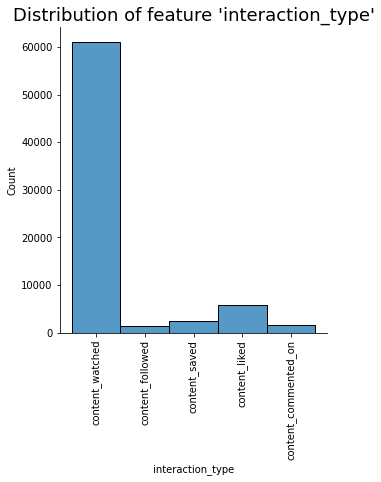

In [14]:
#Visualising distribution of interaction type
plt.figure(figsize=(9,12))
sns.displot(df_consumer, x="interaction_type")
plt.title("Distribution of feature 'interaction_type'",fontsize=18)
plt.xticks(rotation = "vertical") # xticks are rotated as the visuallization was not clear

**We can see that the maximum number of consumers are from Sp or Sao Paolo**

Text(0.5, 1.0, 'Distribution of consumer locations')

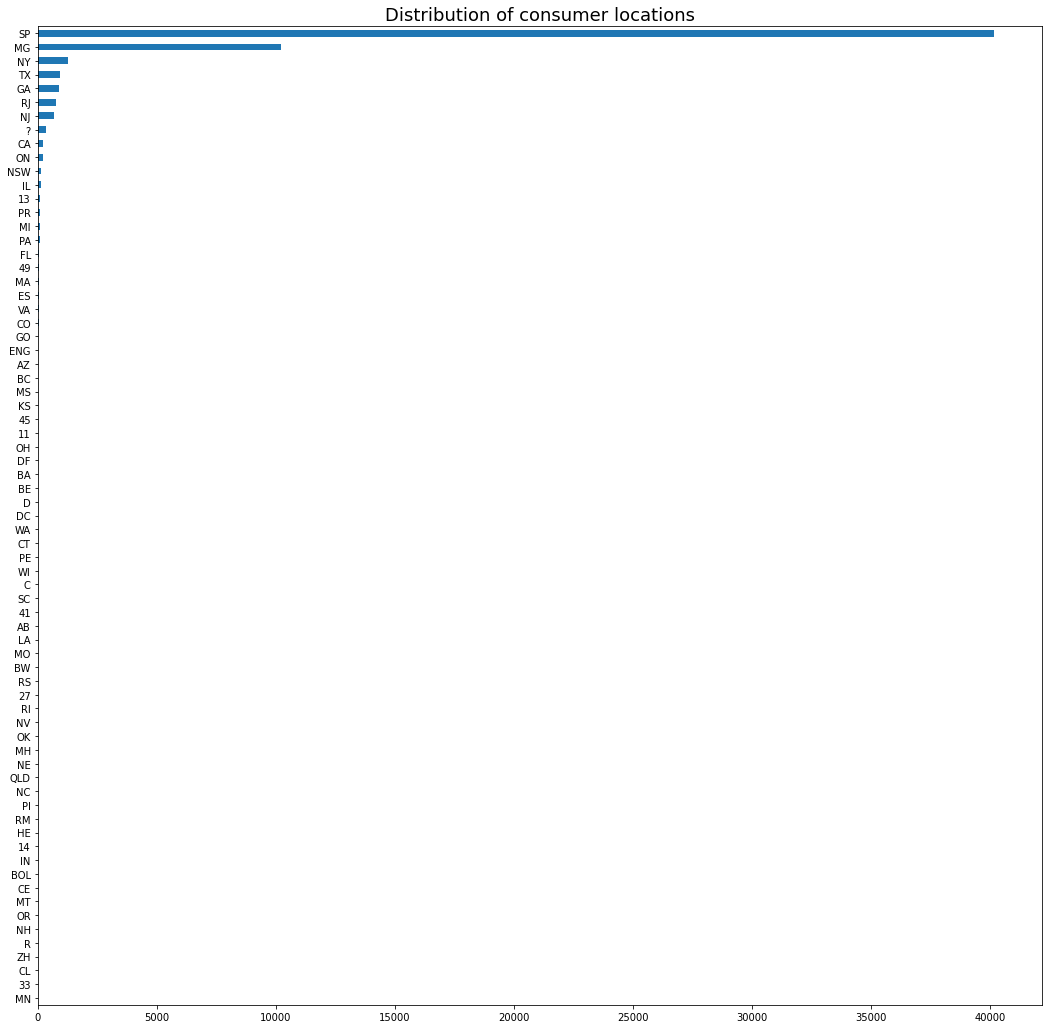

In [15]:
#Visualising distribution of consumer locations 
df_consumer.consumer_location.value_counts().sort_values().plot(kind = 'barh',figsize=(18,18))
plt.title("Distribution of consumer locations",fontsize=18)

Text(0.5, 1.0, 'Distribution of consumer countries')

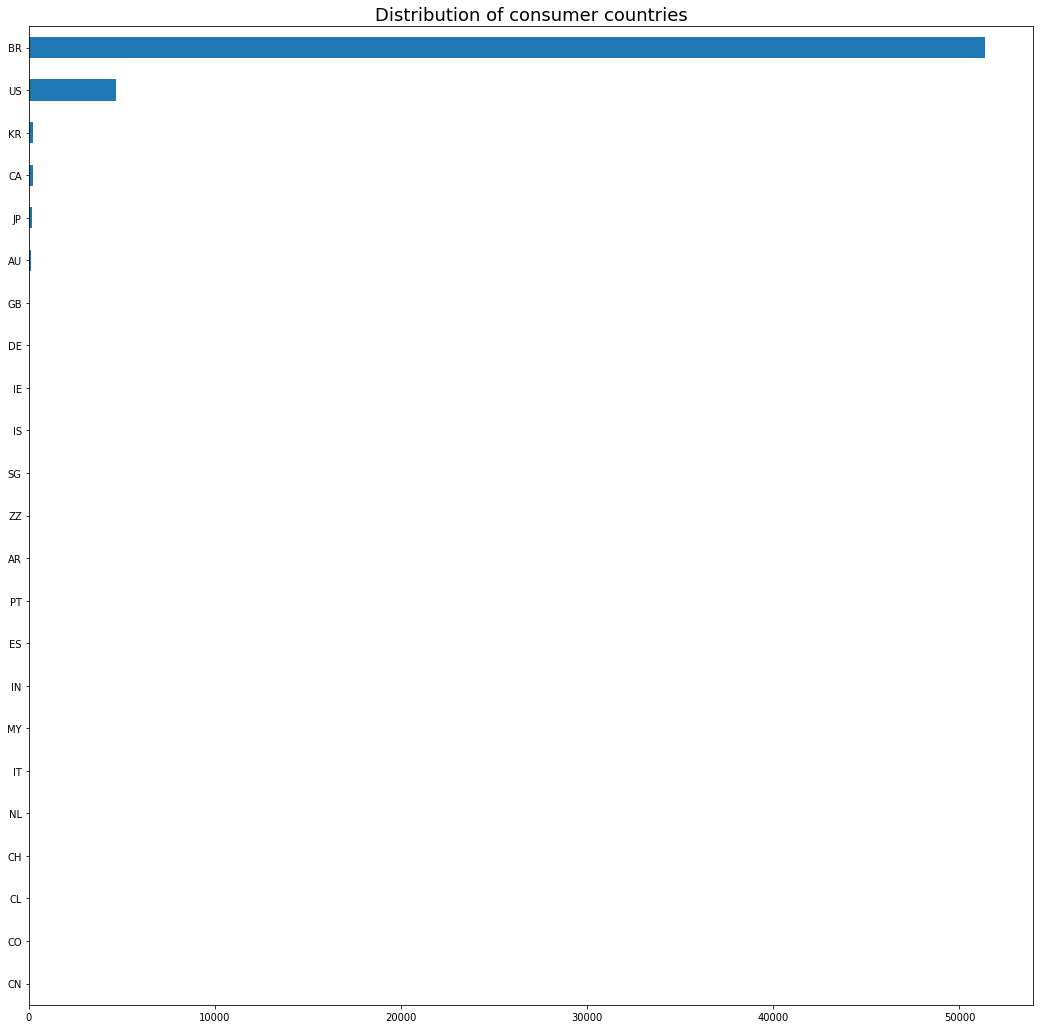

In [16]:
#Plot2
#Visualising distribution of country 
df_consumer.country.value_counts().sort_values().plot(kind = 'barh',figsize=(18,18))
plt.title("Distribution of consumer countries",fontsize=18)

**We can see that the maximum number of consumers are from BR or Brazil**

In [17]:
df_consumer.consumer_device_info.value_counts(normalize=True)

Android - Native Mobile App                                                                                                                         0.118785
Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36                                      0.032029
Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/52.0.2743.116 Safari/537.36                                      0.020134
Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/52.0.2743.116 Safari/537.36                                           0.018904
Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36                                       0.018606
                                                                                                                                                      ...   
Mozilla/5.0 (Linux; Android 6.0.1; Nexus 6P Build/MTC19T) 

**We can see that almost 12% of the consumers use Android - Native Mobile App**

## EDA - platform

In [18]:
df_platform.shape

(3122, 13)

In [19]:
df_platform.head()

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
0,1459192779,content_pulled_out,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,content_present,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,content_present,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,content_present,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


In [20]:
df_platform.describe()

,event_timestamp,item_id,producer_id,producer_session_id
count,3.122000e+03,3.122000e+03,3.122000e+03,3.122000e+03
mean,1.468804e+09,3.284110e+16,3.984819e+17,1.976675e+17
std,7.571512e+06,5.383734e+18,4.387115e+18,5.403753e+18
min,1.459193e+09,-9.222795e+18,-9.120686e+18,-9.212055e+18
25%,1.462369e+09,-4.660869e+18,-1.578288e+18,-4.651280e+18
50%,1.467136e+09,4.436584e+16,-7.092877e+17,4.154103e+17
75%,1.473873e+09,4.745617e+18,3.609194e+18,4.841644e+18
max,1.488308e+09,9.222265e+18,9.210531e+18,9.221043e+18


In [21]:
df_platform.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3122 entries, 0 to 3121
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   event_timestamp       3122 non-null   int64 
 1   interaction_type      3122 non-null   object
 2   item_id               3122 non-null   int64 
 3   producer_id           3122 non-null   int64 
 4   producer_session_id   3122 non-null   int64 
 5   producer_device_info  680 non-null    object
 6   producer_location     680 non-null    object
 7   producer_country      680 non-null    object
 8   item_type             3122 non-null   object
 9   item_url              3122 non-null   object
 10  title                 3122 non-null   object
 11  text_description      3122 non-null   object
 12  language              3122 non-null   object
dtypes: int64(4), object(9)
memory usage: 317.2+ KB


**We can see that most of the columns including 'item_id' and 'producer_id' do not have any null values. Null values are present in columns 'producer_device_info', 'producer_location' and 'producer_country'**

Text(0.5, 1.0, 'Distribution of different content languages on platform')

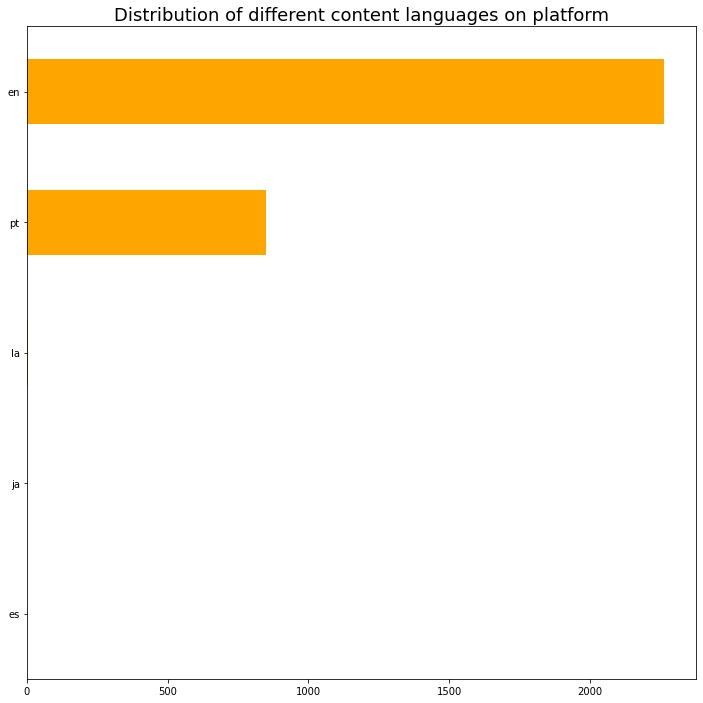

In [22]:
#Visualising distribution of different languages 
df_platform.language.value_counts().sort_values().plot(kind = 'barh',figsize=(12,12),color='orange')
plt.title("Distribution of different content languages on platform",fontsize=18)

**We can observe that most of the majority of content present on the platform is in 'en' or english language followed by 'pt' or portugese**

We will also be filtering the content present in english

In [23]:
content_en = df_platform[df_platform["language"]=="en"]

In [24]:
content_en.shape

(2264, 13)

**We can see that 73% of the data is retained**

In [25]:
# Label Encoding of Item ID in english content and Consumer content.

le_item = LabelEncoder()
content_en["item_index"] = le_item.fit_transform(content_en["item_id"])

df_consumer["item_index"] = le_item.fit_transform(df_consumer["item_id"])


In [26]:
df_consumer

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country,consumer_index,ratings,item_index
0,1465413032,content_watched,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN,33,1,933
1,1465412560,content_watched,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US,831,1,2933
2,1465416190,content_watched,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN,826,1,1537
3,1465413895,content_followed,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN,974,5,1537
4,1465412290,content_watched,-7820640624231356730,-445337111692715325,561148 1178424124714,NaN,NaN,NaN,887,1,246
...,...,...,...,...,...,...,...,...,...,...,...
72307,1485190425,content_liked,-6590819806697898649,-9016528795238256703,8614469745607949425,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4...,MG,BR,17,2,443
72308,1485190425,content_watched,-5813211845057621660,102305705598210278,5527770709392883642,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,945,1,560
72309,1485190072,content_watched,-1999468346928419252,-9196668942822132778,-8300596454915870873,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,SP,BR,4,1,1153
72310,1485190434,content_watched,-6590819806697898649,-9016528795238256703,8614469745607949425,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4...,MG,BR,17,1,443


In [27]:
content_en

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language,item_index
0,1459192779,content_pulled_out,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en,338
1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en,624
2,1459194146,content_present,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en,238
3,1459194474,content_present,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en,369
4,1459194497,content_present,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en,1359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116,1487939756,content_present,4675505028897335428,-1393866732742189886,-1729556941184852519,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,MG,BR,HTML,https://medium.mybridge.co/swift-top-10-articl...,Swift Top 10 Articles For The Past Year (v.2017),"For the past year , we've ranked nearly 9,000 ...",en,1638
3118,1487947067,content_present,-3295913657316686039,6960073744377754728,-8193630595542572738,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_3...,GA,US,HTML,https://thenextweb.com/apps/2017/02/14/amazon-...,Amazon takes on Skype and GoToMeeting with its...,"Amazon has launched Chime, a video conferencin...",en,723
3119,1488223224,content_present,3618271604906293310,1908339160857512799,-183341653743161643,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_0...,SP,BR,HTML,https://code.org/about/2016,Code.org 2016 Annual Report,"February 9, 2017 - We begin each year with a l...",en,1523
3120,1488300719,content_present,6607431762270322325,-1393866732742189886,2367029511384577082,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,MG,BR,HTML,https://www.bloomberg.com/news/articles/2017-0...,JPMorgan Software Does in Seconds What Took La...,"At JPMorgan Chase & Co., a learning machine is...",en,1884


### Analysing english content

Text(0.5, 1.0, 'Distribution of item type')

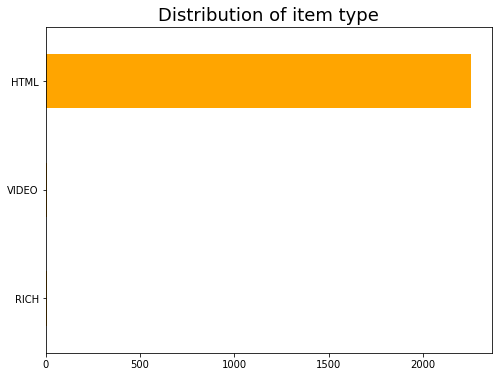

In [28]:
#Visualising distribution of different languages 
content_en.item_type.value_counts().sort_values().plot(kind = 'barh',figsize=(8,6),color='orange')
plt.title("Distribution of item type",fontsize=18)

**we can see that most of the contents are of 'HTML' type**

Text(0.5, 1.0, 'Distribution of producer country')

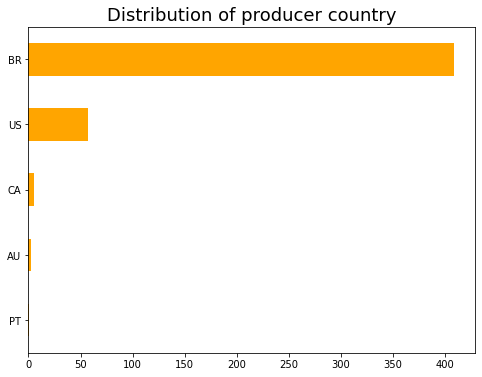

In [29]:
#Visualising distribution of different languages 
content_en.producer_country.value_counts().sort_values().plot(kind = 'barh',figsize=(8,6),color='orange')
plt.title("Distribution of producer country",fontsize=18)

**Most of the producers are based out of 'Br' or 'Brazil'**

Text(0.5, 1.0, 'Distribution of producer location')

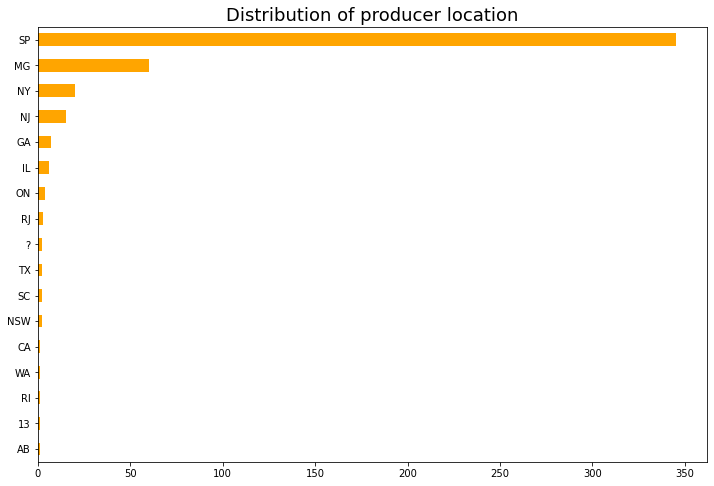

In [30]:
#Visualising distribution of different languages 
content_en.producer_location.value_counts().sort_values().plot(kind = 'barh',figsize=(12,8),color='orange')
plt.title("Distribution of producer location",fontsize=18)

**Most of the productions happen in Sp or Sao Paolo**

In [31]:
content_en.producer_device_info.value_counts(normalize=True)

Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36               0.071882
Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.116 Safari/537.36                   0.069767
Android - Native Mobile App                                                                                                 0.063425
Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.143 Safari/537.36                   0.057082
Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36                    0.040169
                                                                                                                              ...   
Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.143 Safari/537.36          0.002114
Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, l

**We can see that Mozilla is the most commonly used browser**

# Recommendation Techniques

### Content-based filtering

- Use text processing to analyse the ‘keywords’ feature in the data set.
- Recommend similar items based on the TF-IDF scores.

In [32]:
#Selecting the relevant data from content_en dataframe
content_en_final = content_en[['item_index', 'title','text_description']]

In [33]:
content_en_final.head()

,item_index,title,text_description
0,338,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...
1,624,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...
2,238,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...
3,369,Google Data Center 360° Tour,We're excited to share the Google Data Center ...
4,1359,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...


In [34]:
content_en_final["text_description"][0]

'All of this work is still very early. The first full public version of the Ethereum software was recently released, and the system could face some of the same technical and legal problems that have tarnished Bitcoin. Many Bitcoin advocates say Ethereum will face more security problems than Bitcoin because of the greater complexity of the software. Thus far, Ethereum has faced much less testing, and many fewer attacks, than Bitcoin. The novel design of Ethereum may also invite intense scrutiny by authorities given that potentially fraudulent contracts, like the Ponzi schemes, can be written directly into the Ethereum system. But the sophisticated capabilities of the system have made it fascinating to some executives in corporate America. IBM said last year that it was experimenting with Ethereum as a way to control real world objects in the so-called Internet of things. Microsoft has been working on several projects that make it easier to use Ethereum on its computing cloud, Azure. "Et

In [35]:
# check text description string length
content_en_final["text_description"].str.len()

0        6543
1        6543
2        1993
3        1520
4        8093
        ...  
3116     1006
3118     1703
3119    16970
3120     6530
3121      346
Name: text_description, Length: 2264, dtype: int64

In [36]:
### Calculate no of key wrods in all rows by splitting words at space
number_of_keywords = []
for keywords in content_en_final["text_description"]:
    n_keywords = len(keywords.split())
    number_of_keywords.append(n_keywords)

In [37]:
number_of_keywords

[1072,
 1072,
 311,
 272,
 1354,
 276,
 689,
 727,
 1689,
 782,
 1839,
 3877,
 267,
 2178,
 926,
 803,
 181,
 606,
 971,
 545,
 888,
 284,
 276,
 784,
 582,
 609,
 171,
 1407,
 392,
 442,
 373,
 3680,
 1380,
 732,
 377,
 2060,
 461,
 2244,
 403,
 710,
 1465,
 588,
 273,
 4071,
 829,
 432,
 953,
 579,
 313,
 1075,
 1392,
 625,
 291,
 520,
 618,
 1367,
 281,
 627,
 856,
 425,
 247,
 1432,
 366,
 581,
 1248,
 184,
 178,
 248,
 163,
 684,
 976,
 1713,
 6934,
 936,
 976,
 6647,
 976,
 976,
 976,
 976,
 976,
 593,
 2528,
 126,
 832,
 1783,
 224,
 620,
 330,
 435,
 1296,
 610,
 806,
 53,
 69,
 186,
 712,
 666,
 657,
 229,
 844,
 829,
 737,
 697,
 1081,
 53,
 437,
 101,
 1063,
 356,
 453,
 877,
 546,
 915,
 857,
 244,
 493,
 441,
 2753,
 942,
 2309,
 192,
 1101,
 1558,
 219,
 337,
 1163,
 431,
 497,
 637,
 255,
 303,
 198,
 2850,
 748,
 4037,
 243,
 1038,
 362,
 914,
 1017,
 651,
 986,
 1651,
 493,
 767,
 873,
 313,
 945,
 498,
 2966,
 253,
 773,
 961,
 477,
 310,
 141,
 378,
 691,
 503,
 368,

In [38]:
sum(number_of_keywords)

2277726

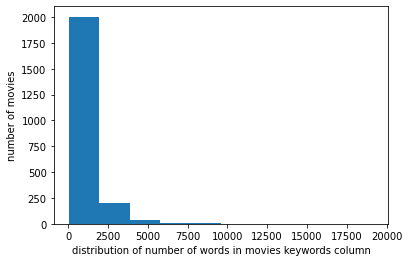

In [39]:
# potting distribution based on number of words
plt.hist(number_of_keywords)
plt.xlabel('distribution of number of words in movies keywords column')
plt.ylabel('number of movies')
plt.show()

In [40]:
#Create numpy array from keywords column
keywords_array = content_en_final['text_description'].to_numpy()

In [41]:
# creating objects to filter the stopwords and puncutation by using NLTK 
#nltk.download('stopwords')

stops = stopwords.words("english")
punc = string.punctuation

In [42]:
# create a function to preprocess data. Steps include removing the stopwords and punctuation, converting sentence to lower case,
# splitting the sentnece to words at Space, removing the stop words and punctuation and returning the wordlist


def preprocess(keywords_array):
    words_list = []
    for keyword in keywords_array:
        splitted_words = keyword.lower().split()
        splitted_words = [word for word in splitted_words if word not in stops and word not in string.punctuation  ]
        words_list.append(splitted_words)
    return words_list

In [43]:
words_list = preprocess(keywords_array) # perform the function call with all the keywords array

In [44]:
# lets see if we got the desired output
words_list[0]

['work',
 'still',
 'early.',
 'first',
 'full',
 'public',
 'version',
 'ethereum',
 'software',
 'recently',
 'released,',
 'system',
 'could',
 'face',
 'technical',
 'legal',
 'problems',
 'tarnished',
 'bitcoin.',
 'many',
 'bitcoin',
 'advocates',
 'say',
 'ethereum',
 'face',
 'security',
 'problems',
 'bitcoin',
 'greater',
 'complexity',
 'software.',
 'thus',
 'far,',
 'ethereum',
 'faced',
 'much',
 'less',
 'testing,',
 'many',
 'fewer',
 'attacks,',
 'bitcoin.',
 'novel',
 'design',
 'ethereum',
 'may',
 'also',
 'invite',
 'intense',
 'scrutiny',
 'authorities',
 'given',
 'potentially',
 'fraudulent',
 'contracts,',
 'like',
 'ponzi',
 'schemes,',
 'written',
 'directly',
 'ethereum',
 'system.',
 'sophisticated',
 'capabilities',
 'system',
 'made',
 'fascinating',
 'executives',
 'corporate',
 'america.',
 'ibm',
 'said',
 'last',
 'year',
 'experimenting',
 'ethereum',
 'way',
 'control',
 'real',
 'world',
 'objects',
 'so-called',
 'internet',
 'things.',
 'microsof

In [45]:
#Creating a dictionary using Gensim
dictionary = Dictionary(words_list)

In [46]:
len(dictionary)

112985

In [47]:
dictionary.get(255)

'million'

In [48]:
#Converting into BOW Model and creating a corpus

corpus = [dictionary.doc2bow(doc) for doc in words_list] 

In [49]:
## Convert the above output to TF IDF Model

tfidf = TfidfModel(corpus)

In [50]:
# Create a similarity matrix
#  Cosine similarity is one of the ways to measure the similarity of two vectors
# Genim uses it as default

sims = MatrixSimilarity(tfidf[corpus], num_features=len(dictionary))

In [51]:
print(sims)

MatrixSimilarity<2264 docs, 112985 features>


In [52]:
sims[corpus[0]]

array([0.9108722 , 0.9108722 , 0.02707533, ..., 0.05927377, 0.06626837,
       0.01561758], dtype=float32)

In [53]:
len(sims[corpus[0]])

2264

### Create a modular code that executes all the previous steps performed

In [54]:
def news_recommendation(item_id):
    news = content_en_final.loc[content_en.item_index==item_id]["text_description"] # get the news row
    keywords = preprocess(news) #using the function we defined earlier for preprocessing
   
    query_doc = keywords #set the query_doc to the list of keywords
    
    query_doc_bow = [dictionary.doc2bow(doc) for doc in query_doc] # get a bag of words from the query_doc
    query_doc_tfidf = tfidf[query_doc_bow] #convert the regular bag of words model to a tf-idf model 
    #where we have tuples of words and it's tf-idf value for the news descriptions

    similarity_array = sims[query_doc_tfidf] # get the array of similarity values 
    #between one News item Text with other News item Text. 
   

    similarity_series = pd.Series(similarity_array.tolist()[0],index=content_en_final.item_index.values) #Convert to a series
    similarity_output = similarity_series.sort_values(ascending=False) #get the top matching results
    return similarity_output 


In [55]:
#Recommended 10 news items for item index 786
item = 786
content_output_news = news_recommendation(item)
content_output_news[:11]

786     1.000000
882     0.242128
633     0.153872
2060    0.040018
1567    0.037369
1567    0.037369
1839    0.035379
1453    0.026775
1891    0.025636
1723    0.025456
24      0.023748
dtype: float64

In [56]:
# Create a DataFrame of the Output
news_content_df = pd.DataFrame(content_output_news[:11]).reset_index()
news_content_df.columns= ["item_index","score"]
news_content_df

,item_index,score
0,786,1.000000
1,882,0.242128
2,633,0.153872
3,2060,0.040018
4,1567,0.037369
5,1567,0.037369
6,1839,0.035379
7,1453,0.026775
8,1891,0.025636
9,1723,0.025456


In [57]:
# Merge the output dataframe with news content dataset to get the title
pd.merge(news_content_df,content_en_final,on="item_index",how="left")

,item_index,score,title,text_description
0,786,1.000000,Julia Galef: Why you think you're right -- eve...,You have JavaScript disabled Perspective is ev...
1,882,0.242128,[Videos] Bill Gross: The single biggest reason...,You have JavaScript disabled Bill Gross has fo...
2,633,0.153872,Blaise Agüera y Arcas: How computers are learn...,You have JavaScript disabled We're on the edge...
3,2060,0.040018,[Videos] This fake TED Talk about nothing migh...,If you've ever clicked on an inspirational vid...
4,1567,0.037369,Learn Swift Programming Syntax | Udacity,"Lesson 1: Swift Basics In this lesson, you'll ..."
5,1567,0.037369,Learn Swift Programming Syntax | Udacity,"Lesson 1: Swift Basics In this lesson, you'll ..."
6,1567,0.037369,Learn Swift Programming Syntax | Udacity,"Lesson 1: Swift Basics In this lesson, you'll ..."
7,1567,0.037369,Learn Swift Programming Syntax | Udacity,"Lesson 1: Swift Basics In this lesson, you'll ..."
8,1839,0.035379,Addressing Accessibility for the Web,Michellanne Li Making sure your website is acc...
9,1453,0.026775,What's the Best Programming Language to Learn ...,Many of you will reflect on your skill set and...


**We can see that system is now capable of making content based recommendations.**

# Collaborative-based filtering

## User Based Collaborative Filtering

- Create user-item matrix using the rating values.
- Find the user-similarity matrix based on a similarity measure.
- Generate predicted ratings for all the user-item pairs.

## Item-based collaborative filtering

- Find the item-similarity matrix based on a similarity measure.
- Generate the top 10 similar and relevant items based on the similarity scores. 

In [58]:
df_consumer.head()

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country,consumer_index,ratings,item_index
0,1465413032,content_watched,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN,33,1,933
1,1465412560,content_watched,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US,831,1,2933
2,1465416190,content_watched,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN,826,1,1537
3,1465413895,content_followed,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN,974,5,1537
4,1465412290,content_watched,-7820640624231356730,-445337111692715325,561148 1178424124714,NaN,NaN,NaN,887,1,246


In [59]:
df_consumer.columns

Index(['event_timestamp', 'interaction_type', 'item_id', 'consumer_id',
       'consumer_session_id', 'consumer_device_info', 'consumer_location',
       'country', 'consumer_index', 'ratings', 'item_index'],
      dtype='object')

In [60]:
#Selecting the relevant data from en_content
consumer_final = df_consumer[['consumer_index', 'item_index','ratings']]

In [61]:
consumer_final.head()

,consumer_index,item_index,ratings
0,33,933,1
1,831,2933,1
2,826,1537,1
3,974,1537,5
4,887,246,1


In [62]:
consumer_final.shape

(72312, 3)

In [63]:
n_users = consumer_final.consumer_index.nunique()

n_items = consumer_final.item_index.nunique()

In [64]:
n_users

1895

In [65]:
n_items

2987

### Splitting the data

In [66]:
# Split the complete datset to Train and test data
from sklearn.model_selection import train_test_split
train, test = train_test_split(consumer_final, test_size=0.30, random_state=42)

### Creating data matrix

In [67]:
# Creating train data matrix
data_matrix_train = np.zeros((n_users, n_items))

In [68]:
data_matrix_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [69]:
data_matrix_train.shape #check matrix shape

(1895, 2987)

In [70]:
train.shape

(50618, 3)

In [71]:
#fill the matrix with training data

for line in train.itertuples():
    data_matrix_train[line[1]-1, line[2]-1] = line[3]

In [72]:
data_matrix_train.nonzero()

(array([   0,    0,    0, ..., 1894, 1894, 1894], dtype=int64),
 array([1153, 1321, 1765, ..., 2834, 2835, 2945], dtype=int64))

In [73]:
#Creating test data matrix
data_matrix_test = np.zeros((n_users, n_items))

In [74]:
#fill the matrix with test data
#each row index represent user and and column index represent items and values represent ratings
for line in test.itertuples():
    data_matrix_test[line[1]-1, line[2]-1] = line[3]

In [75]:
data_matrix_test.shape

(1895, 2987)

In [76]:
data_matrix_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [77]:
data_matrix_full = np.zeros((n_users, n_items))

In [78]:
for line in consumer_final.itertuples():
    data_matrix_full[line[1]-1, line[2]-1] = line[3]

In [79]:
data_matrix_full.shape

(1895, 2987)

### PairWise Distance for user based CF

In [80]:
# Calculate user similarity using the metric cosine distance 
from sklearn.metrics.pairwise import pairwise_distances

user_similarity = 1- pairwise_distances(data_matrix_train, metric='cosine')

In [81]:
user_similarity

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.15384615, 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.1069045 ],
       ...,
       [0.        , 0.15384615, 0.        , ..., 1.        , 0.        ,
        0.04688072],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.02999813],
       [0.        , 0.        , 0.1069045 , ..., 0.04688072, 0.02999813,
        1.        ]])

In [82]:
user_similarity.shape

(1895, 1895)

In [83]:
data_matrix_full.shape

(1895, 2987)

In [84]:
data_matrix_full.T

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [85]:
data_matrix_full.T.shape

(2987, 1895)

### PairWise Distance for item based CF

In [86]:
# Calculate item similarity by using metric cosine distance 
item_similarity = 1-pairwise_distances(data_matrix_train.T, metric='cosine')

In [87]:
item_similarity

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.06163336, ..., 0.08399211, 0.        ,
        0.        ],
       [0.        , 0.06163336, 1.        , ..., 0.17471414, 0.        ,
        0.05661385],
       ...,
       [0.        , 0.08399211, 0.17471414, ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.05661385, ..., 0.        , 0.        ,
        1.        ]])

In [88]:
item_similarity.shape

(2987, 2987)

In [89]:
user_similarity.shape

(1895, 1895)

### Dot product of Data Matrix with Similarity Matrix

In [90]:
# Get the item prediction taking dot product of user similarity and test data matrix
item_prediction = np.dot(user_similarity,data_matrix_test)

In [91]:
item_prediction

array([[0.62057454, 0.07112096, 0.30950479, ..., 0.24053081, 0.        ,
        0.11399657],
       [3.29056256, 0.08054275, 0.42022854, ..., 0.06052275, 0.        ,
        0.0410889 ],
       [0.048795  , 0.10724958, 0.07948031, ..., 0.04323377, 0.        ,
        0.34754887],
       ...,
       [0.35685561, 0.35476435, 0.6354166 , ..., 0.24827113, 0.        ,
        0.14633119],
       [0.15160347, 0.56426279, 0.80650212, ..., 0.39841756, 0.00800102,
        0.11168594],
       [0.24468843, 0.39819056, 0.82855359, ..., 0.58208307, 0.09144599,
        0.83597831]])

In [92]:
item_prediction.shape

(1895, 2987)

In [93]:
#Converting into df
prediction_df = pd.DataFrame(item_prediction)

In [94]:
prediction_df

,0,1,2,3,4,5,6,7,8,9,...,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986
0,0.620575,0.071121,0.309505,0.0,0.133500,0.0,0.066026,0.119523,0.000000,0.153990,...,0.102276,0.037526,0.028499,0.058398,0.012218,0.067035,0.127418,0.240531,0.000000,0.113997
1,3.290563,0.080543,0.420229,0.0,0.140258,0.0,0.223216,0.000000,0.090515,0.054656,...,0.053201,0.000000,0.020544,0.028569,0.017931,0.135295,0.000000,0.060523,0.000000,0.041089
2,0.048795,0.107250,0.079480,0.0,0.000000,0.0,0.082545,0.000000,0.051602,0.000000,...,0.073723,0.079277,0.146343,0.000000,0.030667,0.092915,0.239766,0.043234,0.000000,0.347549
3,0.000000,0.444556,0.161440,0.0,0.176895,0.0,0.000000,0.023570,0.000000,0.084744,...,0.000000,0.000000,0.034816,0.000000,0.014456,0.034100,0.015881,0.061142,0.040324,0.034816
4,0.158114,0.106075,0.297068,0.0,0.115453,0.0,0.008886,0.018634,0.000000,0.018634,...,0.038072,0.048925,0.008886,0.036418,0.070354,0.132026,0.127301,0.370559,0.000000,0.035545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890,0.000000,0.096004,0.277372,0.0,0.023783,0.0,0.270361,0.029235,0.045258,0.041881,...,0.223164,0.009179,0.027884,0.023357,0.017931,0.086873,0.159037,0.027805,0.025008,0.111534
1891,0.113676,0.205769,0.343541,0.0,0.081508,0.0,0.044230,0.059761,0.000000,0.163164,...,0.220543,0.047377,0.028248,0.046483,0.012218,0.183867,0.101340,0.173432,0.017040,0.096716
1892,0.356856,0.354764,0.635417,0.0,0.338341,0.0,0.352306,0.087706,0.045258,0.207628,...,0.263085,0.084274,0.063049,0.014284,0.053793,0.157127,0.207186,0.248271,0.000000,0.146331
1893,0.151603,0.564263,0.806502,0.0,0.400698,0.0,0.247459,0.028061,0.032593,0.193671,...,0.138252,0.048676,0.051527,1.213286,0.277419,0.325217,0.098948,0.398418,0.008001,0.111686


### get recommendation for user 780

In [95]:
prediction_df.iloc[780]

0       0.206078
1       0.338471
2       0.607603
3       0.000000
4       0.339637
          ...   
2982    0.367819
2983    0.319238
2984    0.419136
2985    0.060771
2986    0.627802
Name: 780, Length: 2987, dtype: float64

In [96]:
prediction_df.iloc[780].sort_values(ascending=False)[:10]

846     7.233017
1017    7.000522
2820    6.514254
405     5.419062
2618    5.329263
187     4.973111
134     4.326137
1706    4.278541
2818    4.248105
2463    3.945739
Name: 780, dtype: float64

In [97]:
# Create an DataFrame of prediction content
recommended_news_df = pd.DataFrame(prediction_df.iloc[1893].sort_values(ascending=False))


In [98]:
recommended_news_df

,1893
2695,6.318163
2860,6.000987
1976,4.258427
2675,3.335756
2070,3.190483
...,...
1352,0.000000
1966,0.000000
1970,0.000000
1971,0.000000


In [99]:
recommended_news_df.reset_index(inplace=True)

In [100]:
recommended_news_df.columns = ['item_index', 'score']

In [101]:
recommended_news_df.head()

,item_index,score
0,2695,6.318163
1,2860,6.000987
2,1976,4.258427
3,2675,3.335756
4,2070,3.190483


In [102]:
#merging the prediction with news title
merged_user_based = pd.merge(recommended_news_df,content_en_final,on="item_index",how="left")

In [103]:
# since the shape is different we will also be dropping null values
merged_user_based.dropna(inplace=True)

In [104]:
merged_user_based

,item_index,score,title,text_description
2,1976,4.258427,Linux at 25: Q&A With Linus Torvalds,Photo: Ian White/Corbis Linus Torvalds created...
4,2070,3.190483,Top 5 open source command shells for Linux,There are two kinds of Linux users: the cautio...
5,416,3.178863,Inbox by Gmail: a better way to keep track of ...,Life can get really busy. Inboxes too. Just th...
6,1714,3.011950,Meet Parsey's Cousins: Syntax for 40 languages...,"Just in time for ACL 2016 , we are pleased to ..."
7,1848,2.937371,3 Big Blockchain Ideas MIT is Working on Right...,When one of the world's most prestigious unive...
...,...,...,...,...
3028,1352,0.000000,Thorium,"On September 12, 1932, a man named Leo Szilard..."
3029,1966,0.000000,Announcing .NET Core 1.0,We are excited to announce the release of .NET...
3030,1970,0.000000,Self-Driving Cars and Insurance,THE TOPIC Each new generation of cars is equip...
3031,1971,0.000000,The Gold Mine: A Novel of Lean Turnaround,"Format: Paperback Just in time for summer, the..."


### Normalize the score

In [105]:
merged_user_based["normalized_score"] = (merged_user_based["score"] - merged_user_based["score"].min())/(merged_user_based["score"].max()- merged_user_based["score"].min())

In [106]:
merged_user_based.head(10)

,item_index,score,title,text_description,normalized_score
2,1976,4.258427,Linux at 25: Q&A With Linus Torvalds,Photo: Ian White/Corbis Linus Torvalds created...,1.000000
4,2070,3.190483,Top 5 open source command shells for Linux,There are two kinds of Linux users: the cautio...,0.749216
5,416,3.178863,Inbox by Gmail: a better way to keep track of ...,Life can get really busy. Inboxes too. Just th...,0.746488
6,1714,3.011950,Meet Parsey's Cousins: Syntax for 40 languages...,"Just in time for ACL 2016 , we are pleased to ...",0.707292
7,1848,2.937371,3 Big Blockchain Ideas MIT is Working on Right...,When one of the world's most prestigious unive...,0.689778
8,508,2.905792,Globant Recognized as a Worldwide Leader of Di...,"SAN FRANCISCO, June 14, 2016 /PRNewswire/ -- G...",0.682363
9,1479,2.856870,How will bots make money? Here are 7 business ...,Another bot (hot damn) Called a police and a f...,0.670875
10,846,2.765620,The 24 best restaurants in New York City,Yelp/Daniel With so many restaurants to choose...,0.649446
11,1595,2.740285,The future of agriculture - Jim Womack visits ...,WOMACK'S YOKOTEN - Lean in agriculture might s...,0.643497
12,542,2.728393,Google lags behind Amazon and Microsoft's clou...,Thomson Reuters Google's cloud service may wan...,0.640705


## Performace Evaluation on User based Collaborative filtering

First we will be calculating the offline evaluation metrics like Mean Abosulte error(MAE) or Root mean squared error(RMSE)
However, these metrics are not that accurate so we will also be using global evaluation metrics later on..

In [107]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,accuracy_score
from math import sqrt

### MAE

In [108]:
# Creating a function for calculating MAE

def mae(prediction,ground_truth):
    prediction = prediction[ground_truth.nonzero()]
    ground_truth = ground_truth[ground_truth.nonzero()]
    return mean_absolute_error(prediction,ground_truth)

In [109]:
# call the function mae
mae(item_prediction,data_matrix_test)

1.2301490167425138

### RMSE

In [110]:
# Creating a function for calculating RMSE

def rmse(prediction,ground_truth):
    prediction = prediction[ground_truth.nonzero()]
    ground_truth = ground_truth[ground_truth.nonzero()]
    return sqrt(mean_squared_error(prediction,ground_truth))

In [111]:
rmse(item_prediction,data_matrix_test)

1.9074554632780087

## Model Based Collaborative Filtering

### ALS
- Create Compressed Sparse user-item and item-user matrices. 
- Train the ALS model and generate recommendations for a user. Try experimenting with the hyperparameters.

### Create sparse user-item matrix

In [112]:
from scipy.sparse import csr_matrix

In [113]:
alpha = 40 #assigning a random value

In [114]:
consumer_final.head()

,consumer_index,item_index,ratings
0,33,933,1
1,831,2933,1
2,826,1537,1
3,974,1537,5
4,887,246,1


In [115]:
sparse_user_item = csr_matrix( ([alpha]*consumer_final.shape[0], (consumer_final['consumer_index'], consumer_final['item_index']) ))

In [116]:
sparse_user_item 

<1895x2987 sparse matrix of type '<class 'numpy.intc'>'
	with 40710 stored elements in Compressed Sparse Row format>

In [117]:
#Convert to array
csr_user_array = sparse_user_item.toarray() # convert to numpy array

In [118]:
csr_user_array

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0, 80,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int32)

In [119]:
csr_user_array.shape

(1895, 2987)

In [120]:
print(sparse_user_item)

  (0, 65)	40
  (0, 160)	40
  (0, 188)	40
  (0, 196)	40
  (0, 314)	320
  (0, 328)	40
  (0, 386)	40
  (0, 417)	40
  (0, 443)	40
  (0, 451)	80
  (0, 453)	80
  (0, 465)	40
  (0, 570)	40
  (0, 702)	80
  (0, 769)	40
  (0, 813)	40
  (0, 819)	80
  (0, 864)	40
  (0, 890)	40
  (0, 1087)	80
  (0, 1358)	40
  (0, 1390)	80
  (0, 1411)	120
  (0, 1618)	40
  (0, 1632)	40
  :	:
  (1894, 1977)	160
  (1894, 2023)	40
  (1894, 2027)	40
  (1894, 2071)	640
  (1894, 2080)	80
  (1894, 2190)	40
  (1894, 2253)	80
  (1894, 2334)	40
  (1894, 2349)	40
  (1894, 2451)	40
  (1894, 2470)	40
  (1894, 2538)	80
  (1894, 2608)	40
  (1894, 2676)	80
  (1894, 2696)	120
  (1894, 2719)	40
  (1894, 2772)	80
  (1894, 2809)	40
  (1894, 2814)	80
  (1894, 2845)	40
  (1894, 2861)	160
  (1894, 2867)	40
  (1894, 2922)	40
  (1894, 2925)	40
  (1894, 2981)	40


### Create Item User Sparse Matrix

In [121]:
sparse_item_user = sparse_user_item.T.tocsr()

In [122]:
sparse_item_user

<2987x1895 sparse matrix of type '<class 'numpy.intc'>'
	with 40710 stored elements in Compressed Sparse Row format>

In [123]:
csr_item_array = sparse_item_user.toarray()
csr_item_array.shape

(2987, 1895)

### Train-test split

In [124]:
import implicit
from implicit.evaluation import train_test_split

In [125]:
# divided the dataset using the train-test split
train_als, test_als = train_test_split(sparse_item_user, train_percentage=0.8)

In [126]:
train_als

<2987x1895 sparse matrix of type '<class 'numpy.intc'>'
	with 32590 stored elements in Compressed Sparse Row format>

In [127]:
test_als

<2987x1895 sparse matrix of type '<class 'numpy.intc'>'
	with 8120 stored elements in Compressed Sparse Row format>

### Building ALS Model

In [128]:
# Build the ALS Model
model = implicit.als.AlternatingLeastSquares(factors=100, regularization=0.1, iterations=25,calculate_training_loss=False)

In [129]:
model

In [130]:
# Training the model
model.fit(train_als)

  0%|          | 0/25 [00:00<?, ?it/s]

In [131]:
# Generating recommendation for user having id 420
user_id = 420

In [132]:
model.recommend(user_id,sparse_item_user[user_id])

(array([1002,  220,  918,  667,  451, 1439,   19,  759,   28,  891]),
 array([0.7063695 , 0.6434188 , 0.6230817 , 0.5847146 , 0.5845073 ,
        0.54194415, 0.53862345, 0.50424993, 0.4761725 , 0.46712798],
       dtype=float32))

In [133]:
#now saving these recommendations
output = model.recommend(user_id,sparse_item_user[user_id])

In [134]:
output1 = np.array(output[0])
output2 = np.array(output[1])

In [135]:
output = np.stack((output1,output2),axis=1)

In [136]:
output_df = pd.DataFrame(output, columns=['item_index', 'als_score'])

In [137]:
output_df

,item_index,als_score
0,1002.0,0.706370
1,220.0,0.643419
2,918.0,0.623082
3,667.0,0.584715
4,451.0,0.584507
5,1439.0,0.541944
6,19.0,0.538623
7,759.0,0.504250
8,28.0,0.476173
9,891.0,0.467128


In [138]:
#converting all movie_id back to integer
output_df['item_index'] = output_df['item_index'].astype(int)

In [139]:
output_df

,item_index,als_score
0,1002,0.706370
1,220,0.643419
2,918,0.623082
3,667,0.584715
4,451,0.584507
5,1439,0.541944
6,19,0.538623
7,759,0.504250
8,28,0.476173
9,891,0.467128


In [140]:
#merging the database to get titles
merged_als = pd.merge(output_df,content_en,on="item_index",how="left")
merged_als = merged_als[["item_index","als_score","title"]].dropna().reset_index(drop=True)

In [141]:
merged_als

,item_index,als_score,title
0,1002,0.706370,The Drive to Bank on Digital
1,220,0.643419,Building Products
2,918,0.623082,Drush 9 Roadmap
3,667,0.584715,"Finally, CSS In JavaScript! Meet CSSX - Smashi..."
4,451,0.584507,"Google Cloud Platform adds two new regions, 10..."
5,1439,0.541944,Prototyping across borders - From Tulsa to Bra...
6,19,0.538623,3 Skills That All Emotionally Intelligent Peop...
7,759,0.504250,Farmers Demand Right to Fix Their Own Dang Tra...
8,28,0.476173,Browser Ball
9,891,0.467128,Google's OnHub router finally gets some smart ...


In [142]:
#Normalising the score
# min max normalization 
merged_als["normalized_als_score"] =  (merged_als["als_score"] - merged_als["als_score"].min())/(merged_als["als_score"].max()- merged_als["als_score"].min())

In [143]:
#Top 10 recommendation for user having id 420
merged_als.head(10)

,item_index,als_score,title,normalized_als_score
0,1002,0.706370,The Drive to Bank on Digital,1.000000
1,220,0.643419,Building Products,0.736874
2,918,0.623082,Drush 9 Roadmap,0.651867
3,667,0.584715,"Finally, CSS In JavaScript! Meet CSSX - Smashi...",0.491497
4,451,0.584507,"Google Cloud Platform adds two new regions, 10...",0.490631
5,1439,0.541944,Prototyping across borders - From Tulsa to Bra...,0.312722
6,19,0.538623,3 Skills That All Emotionally Intelligent Peop...,0.298842
7,759,0.504250,Farmers Demand Right to Fix Their Own Dang Tra...,0.155165
8,28,0.476173,Browser Ball,0.037805
9,891,0.467128,Google's OnHub router finally gets some smart ...,0.000000


In [144]:
# Check the similar users like user index 420
model.similar_users(420)[1:11]

(array([0.9999999 , 0.55154186, 0.49555492, 0.47962806, 0.41956896,
        0.4066681 , 0.40581402, 0.39286405, 0.3914206 , 0.3879227 ],
       dtype=float32),)

In [145]:
## Find the similar items for item id 786

similar_items_als = model.similar_items(786)


In [146]:
similar_items_als[1]

array([1.        , 0.8878225 , 0.4498058 , 0.41730282, 0.41721314,
       0.39853567, 0.37873414, 0.372693  , 0.37123045, 0.3618056 ],
      dtype=float32)

In [147]:
output1 = np.array(similar_items_als[0])
output2 = np.array(similar_items_als[1])

In [148]:
output_als = np.stack((output1,output2),axis=1)

In [149]:
output_df = pd.DataFrame(output_als, columns=['item_index', 'als_score'])

In [150]:
# create the dataframe from the similar items

similar_items_als_df = pd.DataFrame(output_df)
similar_items_als_df

,item_index,als_score
0,786.0,1.000000
1,625.0,0.887823
2,732.0,0.449806
3,3.0,0.417303
4,1746.0,0.417213
5,125.0,0.398536
6,1719.0,0.378734
7,66.0,0.372693
8,1353.0,0.371230
9,877.0,0.361806


In [151]:
# merged the similar items and content 
merged_similar_items_als = pd.merge(similar_items_als_df, content_en_final, how='left', on='item_index')
merged_similar_items_als

,item_index,als_score,title,text_description
0,786.0,1.000000,Julia Galef: Why you think you're right -- eve...,You have JavaScript disabled Perspective is ev...
1,625.0,0.887823,Acquia's Dev Desktop - a Drupal server for beg...,Web development can be complicated. When it co...
2,732.0,0.449806,Google IO 2016: A look at how not to run a lar...,"The keynote was great, the demos are cool and ..."
3,3.0,0.417303,Decentralized Options Exchange Etheropt Uses A...,The price per Ether will be taken from multipl...
4,1746.0,0.417213,Workspace Filter,General Structure The filter.xml consists of a...
5,125.0,0.398536,3Dprintler lets you order a 3D print via chatbot,If you want to 3D print something who do you c...
6,1719.0,0.378734,"Building A Modern, Scalable Backend: Modernizi...",One year ago my consultancy was hired to const...
7,66.0,0.372693,Soylent's new drink will replace your breakfas...,"Soylent, the famed meal replacement that went ..."
8,1353.0,0.371230,Hintjens.com,First: blog:1 Elegant Little Pieces Edited: by...
9,877.0,0.361806,A tougher Turing Test shows that computers sti...,"Siri: Okay, from now on I'll call you ""an ambu..."


## Hybrid Recommendation

- Normalise the scores for content and collaborative filtering and combine them with an appropriate weightage to build a hybrid model.
- Try out hybrids of different types of models that can help recommend items similar to a particular item. For example, Content+Item-based collaborative model, ALS+Item-based collaborative model, ALS+Content-based model, etc.

In [152]:
consumer_final.head()

,consumer_index,item_index,ratings
0,33,933,1
1,831,2933,1
2,826,1537,1
3,974,1537,5
4,887,246,1


### Item based CF

In [153]:
# Create a pivot matirx from consumer data

data_matrix_hybrid = pd.pivot_table(consumer_final,
                                    index="consumer_index",
                                    columns="item_index",
                                    values="ratings").fillna(0)

In [154]:
data_matrix_hybrid.shape # Check the shape

(1895, 2987)

In [155]:
data_matrix_hybrid.T.shape # Get the transpose 

(2987, 1895)

In [156]:
from sklearn.metrics.pairwise import pairwise_distances 

# Calculate the item similarity by taking a transpose of user item matrix
item_similarity = 1- pairwise_distances(data_matrix_hybrid.T, metric='cosine')

In [157]:
item_similarity

array([[1.        , 0.        , 0.        , ..., 0.33068092, 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.06716158,
        0.08061138],
       ...,
       [0.33068092, 0.        , 0.        , ..., 1.        , 0.06174613,
        0.14822286],
       [0.        , 0.        , 0.06716158, ..., 0.06174613, 1.        ,
        0.08331525],
       [0.        , 0.        , 0.08061138, ..., 0.14822286, 0.08331525,
        1.        ]])

In [158]:
item_similarity.shape # Check the shape

(2987, 2987)

### Get Recommendations

In [159]:
news_index = 819

#Create a data frame by tking item similarity matrix.
news_prediction = pd.DataFrame(item_similarity)

In [160]:
news_prediction.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986
0,1.000000,0.000000,0.000000,0.117469,0.168773,0.000000,0.0,0.286817,0.000000,0.000000,...,0.331998,0.237357,0.000000,0.629921,0.000000,0.000000,0.000000,0.330681,0.000000,0.000000
1,0.000000,1.000000,0.000000,0.000000,0.000000,0.040093,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,1.000000,0.123798,0.000000,0.097025,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.127458,0.342005,0.083122,0.000000,0.067162,0.080611
3,0.117469,0.000000,0.123798,1.000000,0.000000,0.098583,0.0,0.107369,0.137361,0.118958,...,0.000000,0.194954,0.097129,0.092144,0.259010,0.086874,0.063343,0.165033,0.179131,0.000000
4,0.168773,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.161608,0.000000,0.204598,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.040093,0.097025,0.098583,0.000000,1.000000,0.0,0.098999,0.000000,0.000000,...,0.000000,0.047535,0.063436,0.000000,0.169163,0.113478,0.227536,0.000000,0.033427,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.286817,0.000000,0.000000,0.107369,0.000000,0.098999,0.0,1.000000,0.000000,0.000000,...,0.078031,0.309761,0.195077,0.123377,0.000000,0.058161,0.212034,0.220972,0.034264,0.082252
8,0.000000,0.000000,0.000000,0.137361,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.235702,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.118958,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,...,0.000000,0.229439,0.102062,0.000000,0.000000,0.000000,0.199681,0.000000,0.000000,0.000000


In [161]:
# create an dataframe of predicted data
item_recommendation = pd.DataFrame(news_prediction.iloc[news_index].sort_values(ascending=False))
item_recommendation

,819
819,1.000000
620,0.524865
1500,0.522644
2537,0.492920
209,0.491697
...,...
808,0.000000
2059,0.000000
810,0.000000
2056,0.000000


In [162]:
# reset the index so that the index will be continuous
item_recommendation.reset_index(inplace=True)

In [163]:
item_recommendation.head()

,index,819
0,819,1.000000
1,620,0.524865
2,1500,0.522644
3,2537,0.492920
4,209,0.491697


In [164]:
item_recommendation.columns = ['item_index', 'score'] # assign columns names to DataFrame
item_recommendation.head()

,item_index,score
0,819,1.000000
1,620,0.524865
2,1500,0.522644
3,2537,0.492920
4,209,0.491697


### Merging with data to display titles

In [165]:
# Check the shape of dataframe whih are to be merged
print(item_recommendation.shape)
print(content_en_final.shape)

(2987, 2)
(2264, 3)


In [166]:
# Merge data frame  to get the Title and Title description
merged_item_based = pd.merge(item_recommendation, content_en_final, on='item_index', how='inner')

In [167]:
merged_item_based.shape

(2264, 4)

In [168]:
merged_item_based.head()

,item_index,score,title,text_description
0,819,1.000000,Building A Better Workforce: 5 Talent Trends W...,As we take a look forward at what's new and wh...
1,620,0.524865,Game of Loans,As Queen-Mother Cersei undertook her walk of s...
2,1500,0.522644,"""It's time for self-directed 'smart' investing...",I recently had the chance to speak to Swanest ...
3,209,0.491697,Building on Slack Saved Our Startup,"From the start, we did everything right with T..."
4,1728,0.489476,Google employees are adding 'Lady' to their jo...,More than 800 members of Google's staff are st...


In [170]:
# If incase any NaN values are there. just remove them
collab_output = merged_item_based[merged_item_based['title'].notna()] 

collab_output[["item_index","score","title"]].head() # check the head

,item_index,score,title
0,819,1.000000,Building A Better Workforce: 5 Talent Trends W...
1,620,0.524865,Game of Loans
2,1500,0.522644,"""It's time for self-directed 'smart' investing..."
3,209,0.491697,Building on Slack Saved Our Startup
4,1728,0.489476,Google employees are adding 'Lady' to their jo...


In [171]:
# normalising using min max normalization
collab_output['collaborative_score_normalized'] = (collab_output['score']-min(collab_output['score']))/(max(collab_output['score'])-min(collab_output['score']))

In [172]:
# Select only required columns
collab_output[["item_index","score","title","collaborative_score_normalized"]].head(10)

,item_index,score,title,collaborative_score_normalized
0,819,1.000000,Building A Better Workforce: 5 Talent Trends W...,1.000000
1,620,0.524865,Game of Loans,0.524865
2,1500,0.522644,"""It's time for self-directed 'smart' investing...",0.522644
3,209,0.491697,Building on Slack Saved Our Startup,0.491697
4,1728,0.489476,Google employees are adding 'Lady' to their jo...,0.489476
5,1589,0.480041,Do Crows Hold Funerals for Their Dead?,0.480041
6,468,0.470536,Coder | Drupal.org,0.470536
7,383,0.456016,"Cloud Shell now GA, and still free",0.456016
8,360,0.444244,8 Books Stanford MBAs Recommend You Read This ...,0.444244
9,1997,0.433920,This motorized wheel adds electric power to yo...,0.433920


## Evaluation using precision@k

In [173]:
# get 10 predicted items
pred_set = merged_item_based["item_index"].values[:10]
pred_set

array([ 819,  620, 1500,  209, 1728, 1589,  468,  383,  360, 1997],
      dtype=int64)

### Check precision of a Consumer Index:

In [174]:
consumer_index = 796

In [175]:
# Filter the items where the consumer has rated 3 or more than 3 to news items
ratings_filtered = consumer_final[(consumer_final["ratings"]>3) & (consumer_final["consumer_index"]==consumer_index)]

In [176]:
ratings_filtered

,consumer_index,item_index,ratings
2272,796,210,4
7458,796,1532,4
16812,796,1251,4
23821,796,1889,5
23827,796,1889,4
23836,796,711,4
26009,796,1889,4
26354,796,574,4
26355,796,468,4
34387,796,1417,5


In [177]:
relevant_set = ratings_filtered.item_index.values
relevant_set


array([ 210, 1532, 1251, 1889, 1889,  711, 1889,  574,  468, 1417, 1417,
       2677, 1868, 2677, 1868, 2513, 2513,  160,  160, 1721, 1721,  592,
        592, 2333, 2333, 2333, 1399, 1399], dtype=int64)

In [178]:
#using & operator to find the intersection
list(set(relevant_set) & set(pred_set))

[468]

In [179]:
precision_at_10 = len(list(set(relevant_set) & set(pred_set)))/10

In [180]:
precision_at_10

0.1

- For consumer_index = 796, the precision comes as 0.1, as the consumer has rated the item 468
- if the consumer has not rated the item, then precision can be zero


### Global Average Precision @K

In [181]:
consumer_final.consumer_index.nunique()

1895

In [182]:
# Calculate the global precision
global_precision = 0
for user_index in range(0,1895):
    user_relevant_set = consumer_final[(consumer_final["ratings"]>=3) & 
                                       (consumer_final["consumer_index"]==user_index)].\
                                        sort_values(by="ratings",ascending=False)["item_index"].tolist()
    
    user_predicted_set = news_prediction.iloc[user_index].sort_values(ascending=False)[:10].index.tolist()
    
    precision_at_10 = (len(list(set(user_relevant_set) & set(user_predicted_set))))/10
    
    if precision_at_10 !=0:  # filter where precision is zero 
        print(user_index,"--->", precision_at_10)
    global_precision = global_precision + precision_at_10

509 ---> 0.2
831 ---> 0.2
1114 ---> 0.1
1286 ---> 0.1
1379 ---> 0.1
1650 ---> 0.1
1884 ---> 0.1


In [183]:
global_precision

0.8999999999999999

In [184]:
# Calculate the Global Average Precision 
global_average_precision = global_precision/consumer_final["consumer_index"].nunique()
global_average_precision

0.00047493403693931396

### Continue with the Content Recommendation prediction :

In [185]:
# create a dataframe from content based model output
content_df = pd.DataFrame(content_output_news)

In [186]:
content_df.head()

,0
786,1.000000
882,0.242128
633,0.153872
2060,0.040018
1567,0.037369


In [187]:
# reset the index to make the index continuous
content_df.reset_index(inplace=True)

In [188]:
content_df.head()

,index,0
0,786,1.000000
1,882,0.242128
2,633,0.153872
3,2060,0.040018
4,1567,0.037369


In [189]:
# assign the column names to content prediction data
content_df.columns = ['item_index', 'score']

In [190]:
content_df.head()

,item_index,score
0,786,1.000000
1,882,0.242128
2,633,0.153872
3,2060,0.040018
4,1567,0.037369


### Normalize score

In [191]:
content_df['content_score_normalized'] = (content_df['score']-min(content_df['score'])) / (max(content_df['score']) - min(content_df['score']))

In [192]:
content_df.head()

,item_index,score,content_score_normalized
0,786,1.000000,1.000000
1,882,0.242128,0.242128
2,633,0.153872,0.153872
3,2060,0.040018,0.040018
4,1567,0.037369,0.037369


In [193]:
# check the shape of dataframe content output
content_df.shape

(2264, 3)

In [194]:
# check the shape of dataframe collaborative output
collab_output.shape

(2264, 5)

### Hybrid Modelling

#### Model1: Collaborative Item based output and Content based output

In [195]:
# merge with content data to get the title information and description 
hybrid_output = pd.merge(collab_output,content_df, how='left', on='item_index')

In [196]:
hybrid_output.head()

,item_index,score_x,title,text_description,collaborative_score_normalized,score_y,content_score_normalized
0,819,1.000000,Building A Better Workforce: 5 Talent Trends W...,As we take a look forward at what's new and wh...,1.000000,0.002958,0.002958
1,620,0.524865,Game of Loans,As Queen-Mother Cersei undertook her walk of s...,0.524865,0.001186,0.001186
2,1500,0.522644,"""It's time for self-directed 'smart' investing...",I recently had the chance to speak to Swanest ...,0.522644,0.006135,0.006135
3,209,0.491697,Building on Slack Saved Our Startup,"From the start, we did everything right with T...",0.491697,0.008946,0.008946
4,1728,0.489476,Google employees are adding 'Lady' to their jo...,More than 800 members of Google's staff are st...,0.489476,0.000518,0.000518


In [197]:
# display data
hybrid_output[["score_x","collaborative_score_normalized", "score_y", "content_score_normalized"]].head()

,score_x,collaborative_score_normalized,score_y,content_score_normalized
0,1.000000,1.000000,0.002958,0.002958
1,0.524865,0.524865,0.001186,0.001186
2,0.522644,0.522644,0.006135,0.006135
3,0.491697,0.491697,0.008946,0.008946
4,0.489476,0.489476,0.000518,0.000518


### Calculate the weighted average of two models:

In [198]:
# calculating mean value of the two columns
hybrid_output['final_score'] = (hybrid_output['collaborative_score_normalized'] + hybrid_output['content_score_normalized'])/2

In [199]:
# show only the required columns
hybrid_output[["item_index","score_x","collaborative_score_normalized", "score_y", "content_score_normalized","final_score"]]

,item_index,score_x,collaborative_score_normalized,score_y,content_score_normalized,final_score
0,819,1.000000,1.000000,0.002958,0.002958,0.501479
1,620,0.524865,0.524865,0.001186,0.001186,0.263025
2,1500,0.522644,0.522644,0.006135,0.006135,0.264390
3,209,0.491697,0.491697,0.008946,0.008946,0.250322
4,1728,0.489476,0.489476,0.000518,0.000518,0.244997
...,...,...,...,...,...,...
2353,808,0.000000,0.000000,0.009891,0.009891,0.004945
2354,2059,0.000000,0.000000,0.008913,0.008913,0.004457
2355,810,0.000000,0.000000,0.005551,0.005551,0.002775
2356,2056,0.000000,0.000000,0.000000,0.000000,0.000000


## Hybrid Model 2
### ALS User based + User based collaborative filtering:

In [200]:
## User Based Collaborative Filtering with User Index 623
## Create a dataframe from predicted data
## assign column names 
## combine with conent dataframe to get the title for easy interpretation
## perform the min max normalization

recommended_news_df1 = pd.DataFrame(prediction_df.iloc[623].sort_values(ascending=False))
recommended_news_df1.reset_index(inplace=True)
# recommended_news_df1.head()
recommended_news_df1.columns = ["item_index","score"]
merged_user_based1 = pd.merge(recommended_news_df1,content_en_final,on="item_index",how="left")
merged_user_based1.dropna(inplace=True)
merged_user_based1
merged_user_based1["normalized_score"] = (merged_user_based1["score"] - merged_user_based1["score"].min())/(merged_user_based1["score"].max()- merged_user_based1["score"].min())

In [201]:
merged_user_based1.head()

,item_index,score,title,text_description,normalized_score
0,405,15.007504,"""We only hire the best"" - Signal v. Noise","""We only hire the best"" How many times have yo...",1.000000
3,846,4.382523,The 24 best restaurants in New York City,Yelp/Daniel With so many restaurants to choose...,0.292022
4,1452,4.316721,This is the scientific reason we're addicted t...,"Whether you're working in your office, walking...",0.287638
5,1267,4.312488,How a Japanese cucumber farmer is using deep l...,It's not hyperbole to say that use cases for m...,0.287355
7,771,2.932844,Serverless Architectures,Mike Roberts Mike is an engineering leader liv...,0.195425


#### Merge 2 dataframe:  User based CF and  ALS User Based:

In [202]:
# merge User based CF output and ALS usr based output
hybrid_output_als_user = pd.merge(merged_user_based1,merged_als, how='left', on='item_index').fillna(0)

In [203]:
# create the final score by taking mean of both the normalized score.
hybrid_output_als_user["final_score"] = (hybrid_output_als_user["normalized_score"]+hybrid_output_als_user["normalized_als_score"])/2

In [204]:
# sort the final score and show the result of hybrid model
hybrid_output_als_user.sort_values(by="final_score",ascending=False)[["item_index","title_x","final_score"]].head(4)

,item_index,title_x,final_score
687,1002,The Drive to Bank on Digital,0.505421
0,405,"""We only hire the best"" - Signal v. Noise",0.500000
112,220,Building Products,0.389576
1050,918,Drush 9 Roadmap,0.328792


## Hybrid Model 3 : ALS item based + Content Based

In [205]:
n_recommend = 2987
similar_items_als_1894 = model.similar_items(1894,n_recommend)


In [206]:
similar_items_als_1894

(array([1894, 1287, 1291, ...,    0,    0,    0]),
 array([1.        , 0.44218618, 0.40960744, ..., 0.        , 0.        ,
        0.        ], dtype=float32))

In [207]:
output1 = np.array(similar_items_als_1894[0])
output2 = np.array(similar_items_als_1894[1])

output_als = np.stack((output1,output2),axis=1)

output_df = pd.DataFrame(output_als, columns=['item_index', 'als_score'])
# create the dataframe from the similar items

similar_items_als_1894_df = pd.DataFrame(output_df)
similar_items_als_1894_df

,item_index,als_score
0,1894.0,1.000000
1,1287.0,0.442186
2,1291.0,0.409607
3,143.0,0.397758
4,1830.0,0.397249
...,...,...
2982,0.0,0.000000
2983,0.0,0.000000
2984,0.0,0.000000
2985,0.0,0.000000


In [208]:
similar_items_als_1894_df['item_index'] = similar_items_als_1894_df['item_index'].astype(int)
similar_items_als_1894_df

,item_index,als_score
0,1894,1.000000
1,1287,0.442186
2,1291,0.409607
3,143,0.397758
4,1830,0.397249
...,...,...
2982,0,0.000000
2983,0,0.000000
2984,0,0.000000
2985,0,0.000000


In [209]:
## use the content based model to predict the output of item index 1894
## create the dataframe from predicted output
## assign the appropriate column names

item1 = 1894
content_output_1894 = news_recommendation(item1)
news_content_1894 = pd.DataFrame(content_output_1894).reset_index()
news_content_1894.columns= ["item_index","score"]
news_content_1894

,item_index,score
0,1894,1.000000
1,1192,0.243433
2,983,0.227312
3,1050,0.222530
4,2211,0.221113
...,...,...
2259,1138,0.000000
2260,1107,0.000000
2261,1468,0.000000
2262,2021,0.000000


In [210]:
# perform an left join and combine the both model output.
## fill the NaN value with zero too

als_content_hybrid_merge = pd.merge(similar_items_als_1894_df,news_content_1894,on="item_index",how = "left").fillna(0)

In [211]:
# assign the appropriate column names
als_content_hybrid_merge.columns = ["item_index","score_als","score_content"]

In [212]:
# perform the min max normalization of als score
als_content_hybrid_merge["normalized_score_als"] = (als_content_hybrid_merge["score_als"] - als_content_hybrid_merge["score_als"].min()) /(als_content_hybrid_merge["score_als"].max() - als_content_hybrid_merge["score_als"].min())                                    

In [213]:
# perform the min max normalization of content model score

als_content_hybrid_merge["normalized_score_content"] = (als_content_hybrid_merge["score_content"] - als_content_hybrid_merge["score_content"].min()) /(als_content_hybrid_merge["score_content"].max() - als_content_hybrid_merge["score_content"].min())                                    

In [214]:
als_content_hybrid_merge.head()

,item_index,score_als,score_content,normalized_score_als,normalized_score_content
0,1894,1.000000,1.000000,1.000000,1.000000
1,1287,0.442186,0.010155,0.603962,0.010155
2,1291,0.409607,0.015322,0.580832,0.015322
3,143,0.397758,0.010296,0.572419,0.010296
4,1830,0.397249,0.017309,0.572058,0.017309


In [215]:
## Calculate the final score by taking average of both model score.

als_content_hybrid_merge["final_score"] = (als_content_hybrid_merge["normalized_score_als"] + als_content_hybrid_merge["normalized_score_content"])/2

In [216]:
als_content_hybrid_merge.head() # show the final output

,item_index,score_als,score_content,normalized_score_als,normalized_score_content,final_score
0,1894,1.000000,1.000000,1.000000,1.000000,1.000000
1,1287,0.442186,0.010155,0.603962,0.010155,0.307059
2,1291,0.409607,0.015322,0.580832,0.015322,0.298077
3,143,0.397758,0.010296,0.572419,0.010296,0.291358
4,1830,0.397249,0.017309,0.572058,0.017309,0.294683


## Remove items in prediction which are already rated by User

In [217]:
merged_user_based.head()

,item_index,score,title,text_description,normalized_score
2,1976,4.258427,Linux at 25: Q&A With Linus Torvalds,Photo: Ian White/Corbis Linus Torvalds created...,1.000000
4,2070,3.190483,Top 5 open source command shells for Linux,There are two kinds of Linux users: the cautio...,0.749216
5,416,3.178863,Inbox by Gmail: a better way to keep track of ...,Life can get really busy. Inboxes too. Just th...,0.746488
6,1714,3.011950,Meet Parsey's Cousins: Syntax for 40 languages...,"Just in time for ACL 2016 , we are pleased to ...",0.707292
7,1848,2.937371,3 Big Blockchain Ideas MIT is Working on Right...,When one of the world's most prestigious unive...,0.689778


### Remove News items which the User has already Rated,We do not have to prdict them.
- We also need to remove the items that user has already seen/rated

In [218]:
# filter the data and create the dataframe of actual output
df_user = pd.DataFrame(data_matrix_full[1893],columns=["ratings"])

In [219]:
# check how many items user has already rated in the dataset
df_user["ratings"].value_counts()

0.0    2924
1.0      55
3.0       4
2.0       3
5.0       1
Name: ratings, dtype: int64

In [220]:
df_user.shape 

(2987, 1)

In [221]:
# reset the index for continuous index
df_user = df_user.reset_index()

In [222]:
# assign columns names to filtered data
df_user.columns = ["item_index","ratings"]

In [223]:
df_user.head()

,item_index,ratings
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0


In [224]:
df_user["ratings"].value_counts()

0.0    2924
1.0      55
3.0       4
2.0       3
5.0       1
Name: ratings, dtype: int64

**Consumer has given rating for a total of 63 movies out of 2987 news item Hence we need to remove all these movies from predicted set.**

In [225]:
#Filter already watched movie predicted output
merged_collab = pd.merge(merged_user_based,df_user,on="item_index",how="left")

In [226]:
merged_collab.head()

,item_index,score,title,text_description,normalized_score,ratings
0,1976,4.258427,Linux at 25: Q&A With Linus Torvalds,Photo: Ian White/Corbis Linus Torvalds created...,1.000000,3.0
1,2070,3.190483,Top 5 open source command shells for Linux,There are two kinds of Linux users: the cautio...,0.749216,1.0
2,416,3.178863,Inbox by Gmail: a better way to keep track of ...,Life can get really busy. Inboxes too. Just th...,0.746488,1.0
3,1714,3.011950,Meet Parsey's Cousins: Syntax for 40 languages...,"Just in time for ACL 2016 , we are pleased to ...",0.707292,1.0
4,1848,2.937371,3 Big Blockchain Ideas MIT is Working on Right...,When one of the world's most prestigious unive...,0.689778,1.0


In [227]:
merged_collab.shape

(2264, 6)

In [228]:
# Drop the news items where consumer has already rated

merged_collab = merged_collab.drop(merged_collab[merged_collab["ratings"]>0].index)

In [229]:
# After removing the movie the shape becomes 2219 , Few NaN values we have removed already userbased CF as 
# there was no item information in the Content Dataset.

merged_collab.shape

(2219, 6)

In [230]:

merged_collab.head()

,item_index,score,title,text_description,normalized_score,ratings
7,846,2.765620,The 24 best restaurants in New York City,Yelp/Daniel With so many restaurants to choose...,0.649446,0.0
15,1883,2.027118,Analyzing 50k fonts using deep neural networks,For some reason I decided one night I wanted t...,0.476025,0.0
16,537,1.939461,Failing model: Plastic Card + App and Card + W...,"In the last 4 years, a cluster of players in t...",0.455441,0.0
18,405,1.930121,"""We only hire the best"" - Signal v. Noise","""We only hire the best"" How many times have yo...",0.453247,0.0
20,1095,1.884883,Aggregations,Aggregations grew out of the facets module and...,0.442624,0.0


In [231]:
##  TOP 10 recommendation after removing the entries:
merged_collab["title"][:10]

7              The 24 best restaurants in New York City
15       Analyzing 50k fonts using deep neural networks
16    Failing model: Plastic Card + App and Card + W...
18            "We only hire the best" - Signal v. Noise
20                                         Aggregations
21               CoreOS's rkt Container Engine Hits 1.0
22                   Creating Compound Views on Android
23                             Nights of Cabiria (1957)
26           Arduino clone is as small as an AA battery
29    Google supercharges machine learning tasks wit...
Name: title, dtype: object

## Conclusion

I have followed the following steps in building this Capstone Project:
- Firsly, I started the Exploratory Data Analysis where i analysed distributions of different columns present in the database and plotted visualisations for better understanding of the data. I also did label encoding on important features.
- After EDA, I started with the building of recommendation models. The first recommendation model that i built was Content based filtering using tf-idf approach. After doing all the necessare steps, i used item index 786 to find the top 10 recommendations.
- After Content based RS, I went for the Memory based Collaborative filtering and built the item based and user based recommendation systems.
- After building memory based recommendation systems, I used the user index 780 to recommend the top 10 news items.
- Then I did some model evaluation using offline methods like Root Mean Squared Error(RMSE) and Mean Absolute Error(MAE)
- After Model Evaluation, I performed the Model based Collaborative filtering using ALS (Alternating Least Squares). I also made prediction using this Recommendation System on user id 420.
- After ALS, I build Hybrid recommendation systems with different permutations to find the best output.
- Finally, after all the model building, we used some key evaluation metrics like Precision@k,Global Precision@k to evaluate the model.
- Along with Offline evaluation, online evaluation with human level performance can be used to evaluate the model.
